In [2]:
#!python -m spacy download fr
#!pip install spacy-lefff
#!pip install opendatasets
#!pip install collections
#!pip install keras

In [3]:
import os
import nltk
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [5]:
od.download("https://www.kaggle.com/datasets/nikhileswarkomati/suicide-watch")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: oumarcisse
Your Kaggle Key: ··········


100%|██████████| 60.6M/60.6M [00:01<00:00, 47.1MB/s]


In [6]:
dataset = pd.read_csv("/content/suicide-watch/Suicide_Detection.csv")

In [7]:
dataset.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


<Axes: >

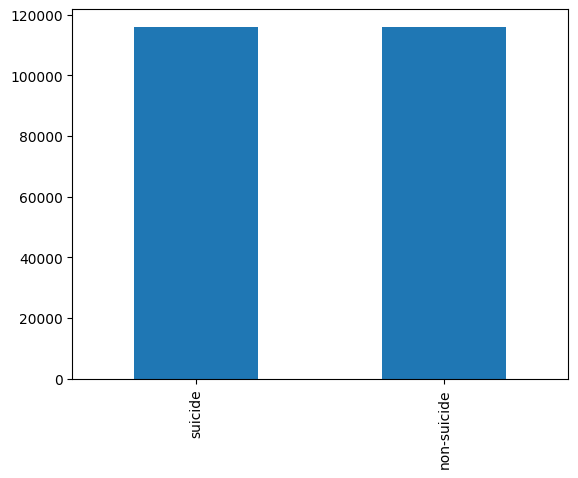

In [8]:
dataset['class'].value_counts().plot(kind='bar')

In [12]:
dataset.shape

(232074, 3)

# Preprocessing

In [219]:
# copy dataset
dataset_copy = dataset.copy()

In [220]:
dataset_copy = dataset_copy.sample(n=50000, random_state=0)

In [221]:
dataset_copy.shape

(50000, 3)

<Axes: >

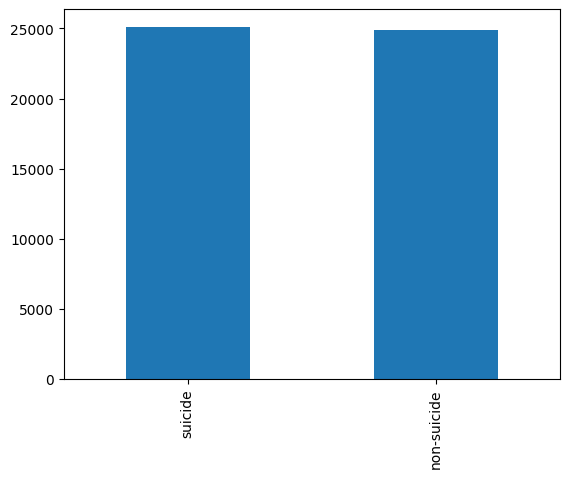

In [222]:
# target vizualisation
dataset_copy['class'].value_counts().plot(kind='bar')

In [223]:
# label
label = {
    0: 'non-suicide',
    1: 'suicide'
}

In [224]:
# Remove column
dataset_copy.drop(['Unnamed: 0'], axis=1, inplace=True)

In [225]:
#encode target variable
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
dataset_copy['class'] = le.fit_transform(dataset_copy['class'])

In [226]:
dataset_copy.head()

,text,class
100974,Saying stuff I’ve never said before I dieDon’t...,1
158546,I was almost hit by a car on the way home toda...,1
154927,Fun reddit fact When you search in the term “c...,0
226574,please help me settle an argument: which is be...,0
81851,28/f - I really need some open minded female f...,1


In [227]:
# preprocess in english
def preprocess(text):
  #tokenize
  token_list = nltk.word_tokenize(text)

  #remove punctuation
  token_list = [word for word in token_list if word.isalpha()]

  # remove url
  token_list = [word for word in token_list if not word.startswith('http')]

  # remove emoji
  token_list = [word for word in token_list if not word.startswith(':') and not word.endswith(':') and not word.startswith(';') and not word.endswith(';')]

  #remove stopwords
  stop_words = nltk.corpus.stopwords.words('english')
  token_list = [word for word in token_list if word not in stop_words]

  #lemmatize
  lemmatizer = nltk.stem.WordNetLemmatizer()
  token_list = [lemmatizer.lemmatize(word) for word in token_list]

  # join
  text = ' '.join(token_list)
  return text

In [228]:
# apply preprocess
dataset_copy['text'] = dataset_copy['text'].apply(preprocess)

In [229]:
dataset_copy.head()

,text,class
100974,Saying stuff I never said I dieDon read help I...,1
158546,I almost hit car way home todayMy body instinc...,1
154927,Fun reddit fact When search term creepy go com...,0
226574,please help settle argument better minecraft p...,0
81851,I really need open minded female friend confid...,1


In [230]:
Y = dataset_copy['class'].values

In [231]:
from collections import Counter

# Count unique words
def counter_word(text):
  count = Counter()

  for i in text.values:
    for word in i.split():
      count[word] += 1
  return count

In [232]:
# Count unique words
counter = counter_word(dataset_copy['text'])
print(len(counter))

70023


*Faire une matrix*

In [233]:
# import pad_sequences
from keras.preprocessing.sequence import pad_sequences

# tokenize
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(dataset_copy['text'])

X = tokenizer.texts_to_sequences(dataset_copy['text'])

In [234]:
len(X)

50000

In [235]:
# pad sequences
maxlength = 100
X = pad_sequences(X, maxlen=maxlength)

In [236]:
print(f'Shape of X {X.shape}')
print(f'Shape of Y {Y.shape}')

Shape of X (50000, 100)
Shape of Y (50000,)


In [237]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

In [238]:
from tensorflow.keras.utils import to_categorical

num_classes = 2

Y_train_one_hot = to_categorical(Y_train, num_classes)
Y_test_one_hot = to_categorical(Y_test, num_classes)

In [239]:
print(f'Shape of X train {X_train.shape}')
print(f'Shape of Y train {Y_train_one_hot.shape}')

Shape of X train (37500, 100)
Shape of Y train (37500, 2)


# Modelling

In [240]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SpatialDropout1D
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.layers import Bidirectional
from keras.layers import GlobalAveragePooling1D
from keras.layers import BatchNormalization
from keras.layers import SimpleRNN

# LSTM

In [247]:
classifier = Sequential()

# embedding layer
classifier.add(Embedding(X_train.shape[0] , 100, input_length=X_train.shape[1], trainable=False))

# dropout
#classifier.add(SpatialDropout1D(0.2))

# LSTM layer
classifier.add(LSTM(100, dropout=0.2, recurrent_dropout=0.1))

# output layer
classifier.add(Dense(num_classes, activation='softmax'))

In [248]:
classifier.compile(
    loss='categorical_crossentropy',
    optimizer= Adam(learning_rate=0.025), #0.0025
    metrics=['accuracy']
)

In [249]:
classifier.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_29 (Embedding)    (None, 100, 100)          3750000   
                                                                 
 lstm_29 (LSTM)              (None, 100)               80400     
                                                                 
 dense_37 (Dense)            (None, 2)                 202       
                                                                 
Total params: 3830602 (14.61 MB)
Trainable params: 80602 (314.85 KB)
Non-trainable params: 3750000 (14.31 MB)
_________________________________________________________________


In [252]:
history = classifier.fit(
    X_train,
    Y_train_one_hot,
    epochs=15,
    verbose=1,
    validation_split=0.2,
    batch_size=128
)

Epoch 1/15
235/235 [==============================] - 56s 236ms/step - loss: 0.5028 - accuracy: 0.7684 - val_loss: 0.4860 - val_accuracy: 0.7783
Epoch 2/15
235/235 [==============================] - 56s 237ms/step - loss: 0.4796 - accuracy: 0.7820 - val_loss: 0.4580 - val_accuracy: 0.7948
Epoch 3/15
235/235 [==============================] - 55s 234ms/step - loss: 0.4561 - accuracy: 0.7942 - val_loss: 0.4413 - val_accuracy: 0.8047
Epoch 4/15
235/235 [==============================] - 55s 235ms/step - loss: 0.4317 - accuracy: 0.8102 - val_loss: 0.4007 - val_accuracy: 0.8309
Epoch 5/15
235/235 [==============================] - 55s 236ms/step - loss: 0.4044 - accuracy: 0.8239 - val_loss: 0.3803 - val_accuracy: 0.8399
Epoch 6/15
235/235 [==============================] - 55s 235ms/step - loss: 0.4039 - accuracy: 0.8277 - val_loss: 0.3782 - val_accuracy: 0.8412
Epoch 7/15
235/235 [==============================] - 55s 235ms/step - loss: 0.3847 - accuracy: 0.8368 - val_loss: 0.3801 - val_ac

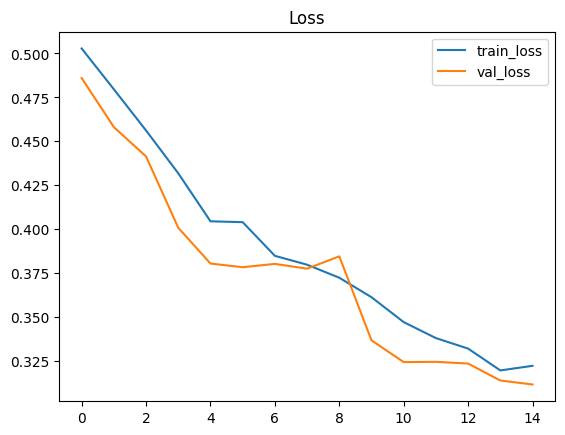

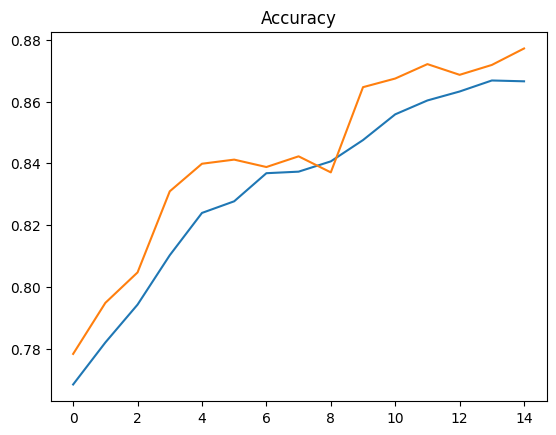

In [253]:
loss_curve = history.history["loss"]
val_loss_curve = history.history["val_loss"]

acc_curve = history.history["accuracy"]
val_acc_curve = history.history["val_accuracy"]

plt.plot(loss_curve,label="train_loss")
plt.plot(val_loss_curve,label="val_loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(acc_curve,label="train_acc")
plt.plot(val_acc_curve,label="val_acc")
plt.title("Accuracy")
plt.show()

In [275]:
# save model
classifier.save('sucide_lstm_acc_0.86.h5')

In [276]:
import tensorflow as tf
loaded_model = tf.keras.models.load_model('./sucide_lstm_acc_0.86.h5')
loss, acc = loaded_model.evaluate(X_test, Y_test_one_hot)
print("Loss: ",loss)
print("Acc: ",acc)

391/391 [==============================] - 12s 30ms/step - loss: 0.3198 - accuracy: 0.8742
Loss:  0.31980764865875244
Acc:  0.8741599917411804


In [273]:
# predict
str_test = 'Ex Wife Threatening SuicideRecently I left my wife for good because she has cheated on me twice and lied to me so much that I have decided to refuse to go back to her. As of a few days ago, she began threatening suicide. I have tirelessly spent these paat'

test_sequences = tokenizer.texts_to_sequences([str_test])
test_padded = pad_sequences(test_sequences, maxlen=maxlength)
test_padded = np.reshape(test_padded, (-1, maxlength, 1))

result = loaded_model.predict(test_padded)
print(result)
print(label[np.argmax(result)])

1/1 [==============================] - 0s 45ms/step
[[0.09350309 0.9064969 ]]
suicide
